# Preparación de datos

In [1]:
# importaciones
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from pandas.plotting import scatter_matrix
from itertools import combinations

## Utilidades

In [2]:
# Configuración

# Esta variable es utilizada para controlar la ejecución de generación de boxplots durante el tratamiento de datos
EJECUCION_RAPIDA = True

# Semilla para asegurar
seed=9603

# Proporción de la muestra extraída del dataset original para entrenar los modelos de Machine Learning
# dataset_size = 0.2173197777948736
dataset_size = 0.0757828836335171
test_size = 0.2
valid_size = 0.25

# Nombres de archivos
dataset_path = "DB/"

db_files_name = ["df_train.csv", "df_test.csv"]

output_paths = ["output/", "../4_modelado/DB/"]

output_files_name = ["X_train.csv", "y_train.csv", "X_test.csv", "y_test.csv"]

img_path = "img/"

managed_path = "managed/"

no_managed_path = "no_managed/"

pca_path = "pca/"

boxplot_path = "boxplot/"

corr_matrix_path = "corr_matrix/"

In [3]:
# Variables

caracteristica_objetivo = ['label']

caracteristicas_nominales = ['destination_port']

caracteristicas_valores_nulos = "flow_bytes/s"

caracteristicas_binarias  = [
      'fwd_psh_flags', 'fwd_urg_flags',
      'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 
      'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 
      'cwe_flag_count', 'ece_flag_count'
]
      
caracteristicas_numericas = [
      'flow_duration', 'total_fwd_packets', 'total_backward_packets', 
      'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 
      'fwd_packet_length_max', 'fwd_packet_length_min', 
      'fwd_packet_length_mean', 'fwd_packet_length_std', 
      'bwd_packet_length_max', 'bwd_packet_length_min', 
      'bwd_packet_length_mean', 'bwd_packet_length_std', 
      'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 
      'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 
      'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 
      'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 
      'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
      'min_packet_length', 'max_packet_length', 'packet_length_mean',
      'packet_length_std', 'packet_length_variance', 'down/up_ratio',
      'average_packet_size', 'avg_fwd_segment_size', 
      'avg_bwd_segment_size', 'fwd_header_length.1', 'subflow_fwd_packets', 
      'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes', 
      'init_win_bytes_forward', 'init_win_bytes_backward', 
      'act_data_pkt_fwd', 'min_seg_size_forward', 'active_mean', 
      'active_std', 'active_max', 'active_min', 'idle_mean', 'idle_std', 
      'idle_max', 'idle_min'
]

caracteristicas_no_utiles = [
      'bwd_psh_flags',
      'bwd_urg_flags', 
      'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 
      'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate'
]

caracteristicas_con_valor_maximo_infinito = [
      'flow_bytes/s', 'flow_packets/s'
]

In [4]:
# getFrequency(): Función para obtener la distribución de frecuencias de la columna label
def getFrequency(df : pd.DataFrame, caracteristica) :
  frecuencia = df[caracteristica].value_counts()
  porcentaje = df[caracteristica].value_counts(normalize=True) * 100

  tabla_frecuencia = pd.DataFrame({
    "Frecuencia": frecuencia,
    "Frecuencia(%)": porcentaje
  })
  
  tabla_frecuencia["Frecuencia(%)"].round(2)
  
  print(tabla_frecuencia)
  print(df.shape)

In [5]:
# generateBoxplot(): Función para generar boxplot 
def generateBoxplot(x, y, data, save_path="", save = True) :
  sns.boxplot(x=x, y=y, data=data)

  plt.xlabel(x)
  plt.ylabel(y)
  plt.title(f"Boxplot {y} {x}")
  plt.tight_layout()
  if save :
    plt.savefig(save_path)
  plt.show()

In [6]:
# generateCorrMatrix(): Función para generar matriz de correlación
def generateCorrMatrix(data, save_path="", title="Matriz de correlación", method="pearson", width=32, height=24, fontsize=12,decimals=2, abs = False, save=True, aplicar_umbral=False, umbral=0.5) :
  # Generación de matriz de correlación
  matriz_correlacion = data.corr(method=method).round(decimals=decimals)

  if abs :
    matriz_correlacion = matriz_correlacion.abs()

  if aplicar_umbral : 
    matriz_correlacion = matriz_correlacion.where(np.abs(matriz_correlacion) >= umbral, 0)

  # Generación de mapa de calor para visualizar los datos
  plt.figure(figsize=(width, height))

  sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(title)
  plt.tight_layout()
  if save :
    plt.savefig(save_path)
  plt.show()
  return matriz_correlacion

## Carga y transformación de datos

### Carga de datos

In [7]:
# Carga de datos
df = pd.read_csv(f"{dataset_path}dataset.csv")
print("Datos cargados")

Datos cargados


### Transformación de nombres de columnas y etiquetas de variable objetivo

In [8]:
# Transformación de nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)
print(f"Total de características: {len(df.columns)}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [9]:
# Transformación de nombres de etiquetas de la columna label
df["label"] = df["label"].str.upper().str.replace("� ", "").str.replace(" ", "_").str.replace("-", "_")
print(df["label"].unique())
print(f"Total de etiquetas: {len(df["label"].unique())}")

['BENIGN' 'FTP_PATATOR' 'SSH_PATATOR' 'DOS_SLOWLORIS' 'DOS_SLOWHTTPTEST'
 'DOS_HULK' 'DOS_GOLDENEYE' 'WEB_ATTACK_BRUTE_FORCE' 'WEB_ATTACK_XSS'
 'BOT' 'PORTSCAN' 'DDOS']
Total de etiquetas: 12


### División en conjuntos de entrenamiento, validación y pruebas

In [10]:
# Frecuencia del conjunto de datos extraído
getFrequency(df=df, caracteristica="label")

                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                     1743179      75.765455
DOS_HULK                    231073      10.043347
PORTSCAN                    158930       6.907726
DDOS                        128027       5.564560
DOS_GOLDENEYE                10293       0.447374
FTP_PATATOR                   7938       0.345017
SSH_PATATOR                   5897       0.256307
DOS_SLOWLORIS                 5796       0.251917
DOS_SLOWHTTPTEST              5499       0.239008
BOT                           1966       0.085450
WEB_ATTACK_BRUTE_FORCE        1507       0.065500
WEB_ATTACK_XSS                 652       0.028338
(2300757, 79)


In [11]:
# Extracción de muestra
df_vector_test, df_temp = train_test_split(
  df, 
  test_size=1-dataset_size, 
  stratify=df["label"], 
  random_state=seed
)

df_vector, df_test = train_test_split(
  df_vector_test,
  test_size=test_size,
  stratify=df_vector_test["label"],
  random_state=seed
)

df_train, df_valid = train_test_split(
  df_vector,
  test_size=valid_size,
  stratify=df_vector["label"],
  random_state=seed
)

print("Dataset para el proyecto")
getFrequency(df=df_vector_test, caracteristica="label")

Dataset para el proyecto
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                      132102      75.765240
DOS_HULK                     17511      10.043187
PORTSCAN                     12044       6.907666
DDOS                          9702       5.564445
DOS_GOLDENEYE                  780       0.447358
FTP_PATATOR                    602       0.345269
SSH_PATATOR                    447       0.256371
DOS_SLOWLORIS                  439       0.251782
DOS_SLOWHTTPTEST               417       0.239164
BOT                            149       0.085457
WEB_ATTACK_BRUTE_FORCE         114       0.065383
WEB_ATTACK_XSS                  50       0.028677
(174357, 79)


In [12]:
# Tablas de frecuencia de conjuntos de entrenamiento, validación y prueba
print("Dataset de entrenamiento")
getFrequency(df=df_train, caracteristica="label")
print("\nDataset de validación")
getFrequency(df=df_valid, caracteristica="label")
print("\nDataset de prueba")
getFrequency(df=df_test, caracteristica="label")

Dataset de entrenamiento
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       79260      75.764962
DOS_HULK                     10507      10.043685
PORTSCAN                      7226       6.907363
DDOS                          5821       5.564318
DOS_GOLDENEYE                  468       0.447363
FTP_PATATOR                    361       0.345081
SSH_PATATOR                    269       0.257138
DOS_SLOWLORIS                  263       0.251403
DOS_SLOWHTTPTEST               251       0.239932
BOT                             89       0.085075
WEB_ATTACK_BRUTE_FORCE          68       0.065001
WEB_ATTACK_XSS                  30       0.028677
(104613, 79)

Dataset de validación
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       26421      75.765657
DOS_HULK                      3502      10.042441
PORTSCAN                      2409     

## Tratamiento del conjunto de entrenamiento

### Selección de datos relevantes

In [13]:
df_train = df_train.drop(caracteristicas_no_utiles, axis=1)
print(df_train.columns)
print(f"N° características: {len(df_train.columns.tolist())}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags',
       'fwd_header_length', 'bwd_header_length', 'fwd_packets/s',
       'bwd_packets/s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count',

### Limpieza de datos

In [14]:
# Imputación de datos faltantes y nulos : flow_bytes/s
# No se identificó una relación mediante la matriz de correlación, sin embargo, se imputarán los datos en razón de la variable objetivo para conservar la mayor información ppsible

# imputacion_con_filtro_datos_faltantes() : Imputación de datos faltantes con la mediana, se aplican las medianas filtrando por la variable objetivo
def imputacion_con_filtro_datos_faltantes(df : pd.DataFrame, caracteristica : str) : 
  imputacion_con_filtro = True
  if imputacion_con_filtro :
    print(df[df[caracteristica].isna()]["label"].value_counts())
    # Se obtienen las etiquetas de la variable objetivo que tienen valores nulos
    null_values_list = df[df[caracteristica].isna()]["label"].unique().tolist()

    for i in null_values_list : 
      # Obtención de mediana de la columna filtrandolo por la variable objetivo
      median = df[df["label"] == i][caracteristica].median()

      # Reemplazo de valores faltantes por la mediana obtenida
      df.loc[df[caracteristica].isnull() & (df["label"] == i), caracteristica] = median

      # Cálculo de posibles características que no se hayan imputado
      rest = df[df["label"] == i][caracteristica].isnull().sum()

      print(f"Mediana de la característica {caracteristica} en la etiqueta {i}: {median}")
      print(f"Valores faltantes en {caracteristica} en {i} después de la imputación: {rest}")
  else : 
    # Posible imputación sin filtros
    # Obtención de mediana general de la columna
    mediana = df[caracteristica].median()

    # Reemplazo de todos los valores faltantes por la mediana general
    df[caracteristica] = df[caracteristica].fillna(mediana)
    print(f"Mediana de la característica {caracteristica}: {mediana}\n")
    print(f"Valores faltantes en {caracteristica}: {df[caracteristica].isnull().sum()}")
  return df

df_train = imputacion_con_filtro_datos_faltantes(df=df_train, caracteristica="flow_bytes/s")

label
DOS_HULK    36
BENIGN      18
Name: count, dtype: int64
Mediana de la característica flow_bytes/s en la etiqueta DOS_HULK: 121.1820345
Valores faltantes en flow_bytes/s en DOS_HULK después de la imputación: 0
Mediana de la característica flow_bytes/s en la etiqueta BENIGN: 5029.361045
Valores faltantes en flow_bytes/s en BENIGN después de la imputación: 0


In [15]:
# Manejo de outliers

# manageOutliersToMinMax() : Función para manejar outliers y transformarlos a los valores mínimos y máximos en un boxplot aplicando filtros en la variable objetivo
def manageOutliersToMinMax(df : pd.DataFrame, col_num, col_obj) :
  df_modificado = df.copy()
  for var_obj in df[col_obj].unique() :
    subset = df[df[col_obj] == var_obj]
    q1 = subset[col_num].quantile(0.25)
    q3 = subset[col_num].quantile(0.75) 
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    valid_values = subset[(subset[col_num] >= lower_bound) & (subset[col_num] <= upper_bound)][col_num]
    valid_min = valid_values.min()
    valid_max = valid_values.max()

    mask = df[col_obj] == var_obj
    df_modificado.loc[mask & (df[col_num] < lower_bound), col_num] = valid_min
    df_modificado.loc[mask & (df[col_num] > upper_bound), col_num] = valid_max
  return df_modificado

# Manejo de outliers para ajustarlos al máximo y mínimo del conjunto de datos según la variable objetivo
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito : 
  df_train = manageOutliersToMinMax(df=df_train,col_num=i,col_obj="label")

print("Outliers manejados")

Outliers manejados


### Creación de nuevos datos

In [16]:
# La característica destination_port es de tipo categórica y tiene alta cardinalidad
# por ello, se aplicará reducción de características mediante la clasificación de IANA
"""
  Clasificación de IANA de puertos
  0 - 1023 : Well-known ports, puertos utilizados por el sistema (o root) o programas con privilegios de usuario 
  1024 - 49151 : Registered ports, puertos utilizados en procesos o programas de usuarios ordinarios
  49152 - 65535 : Dynamic and/or Private ports, puertos privados o dinámicos
"""

chars_encoder = OneHotEncoder(drop="first", sparse_output=False)

bins = [-1, 1023, 49151, 65535]
labels = ["well_known", "registered", "dynamic_private"]
df_train["port_type"] = pd.cut(df_train["destination_port"], bins=bins, labels=labels)

chars_encoded_array = chars_encoder.fit_transform(df_train[["port_type"]])
df_chars_encoded = pd.DataFrame(
  columns=chars_encoder.get_feature_names_out(),
  data=chars_encoded_array
)

df_train = pd.concat(
  [
    df_chars_encoded.reset_index(drop=True), 
    df_train[caracteristicas_binarias + caracteristicas_numericas + caracteristicas_con_valor_maximo_infinito + caracteristica_objetivo].reset_index(drop=True)
  ],
  axis=1
)

df_train

,port_type_registered,port_type_well_known,fwd_psh_flags,fwd_urg_flags,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,...,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,flow_bytes/s,flow_packets/s,label
0,0.0,1.0,0,0,0,0,0,0,1,1,...,0.0,0,0,0.0,0.0,0,0,0.000000,54.473648,BENIGN
1,0.0,1.0,0,0,0,0,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,0.000000,6.383780,BENIGN
2,1.0,0.0,1,0,0,1,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,691983.122400,53333.333330,BENIGN
3,0.0,1.0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0,10933.978800,166.930974,BENIGN
4,1.0,0.0,0,0,0,0,0,1,0,0,...,0.0,0,0,0.0,0.0,0,0,115384.615400,38461.538460,PORTSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104608,0.0,1.0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0,691983.122400,19138.755980,BENIGN
104609,1.0,0.0,1,0,0,1,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,691983.122400,53333.333330,BENIGN
104610,0.0,1.0,0,0,1,0,0,0,0,0,...,0.0,5002,5000,98400000.0,0.0,98400000,98400000,121.417204,0.132141,DOS_HULK
104611,0.0,1.0,0,0,0,0,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,0.000000,5117.707267,DOS_HULK


In [17]:
# SMOTE y Tomek-links son un sistema que funcionan en base a los vecinos más cercanos
# SMOTE es un sistema que realiza un sobremuestreo de la clase minoritaria para equilibrar las clases 
# Tomek-links es un sistema que realiza un submuestreo eliminando registros de la clase minoritaria selectivamente para equlibrar las clases 

In [18]:
# Creación de SMOTE y Tomek links
# SMOTENC() : Permite sobremuestrear registros incluyendo características categóricas
smt_nc = SMOTENC(
  categorical_features=list(range(len(list(chars_encoder.get_feature_names_out()) + caracteristicas_binarias))),
  random_state=seed
)

# TomekLinks() : Elimina registros del dataset de forma determinística, por ello, no es necesario usar una seed
tmk = TomekLinks()

print("Distribución inicial")
getFrequency(df=df_train, caracteristica="label")

Distribución inicial
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       79260      75.764962
DOS_HULK                     10507      10.043685
PORTSCAN                      7226       6.907363
DDOS                          5821       5.564318
DOS_GOLDENEYE                  468       0.447363
FTP_PATATOR                    361       0.345081
SSH_PATATOR                    269       0.257138
DOS_SLOWLORIS                  263       0.251403
DOS_SLOWHTTPTEST               251       0.239932
BOT                             89       0.085075
WEB_ATTACK_BRUTE_FORCE          68       0.065001
WEB_ATTACK_XSS                  30       0.028677
(104613, 72)


In [19]:
# Sobre-muestreo con SMOTE
X_train_resample, y_train_resample = smt_nc.fit_resample(
  df_train.drop(["label"], axis=1),
  df_train["label"] 
)
getFrequency(df=y_train_resample.to_frame(), caracteristica="label")

                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       79260       8.333333
PORTSCAN                     79260       8.333333
DOS_HULK                     79260       8.333333
DDOS                         79260       8.333333
DOS_SLOWLORIS                79260       8.333333
SSH_PATATOR                  79260       8.333333
DOS_GOLDENEYE                79260       8.333333
BOT                          79260       8.333333
WEB_ATTACK_BRUTE_FORCE       79260       8.333333
DOS_SLOWHTTPTEST             79260       8.333333
FTP_PATATOR                  79260       8.333333
WEB_ATTACK_XSS               79260       8.333333
(951120, 1)


In [20]:
# Sub-muestreo con Tomek-links
# Usamos un conjunto para obtener una lista de los índices sin repetir
indices_para_remover = set()
labels = y_train_resample.to_frame()["label"].unique()
cont = 0

for i, j in combinations(labels, 2) :
  print(f"Iteración {cont}")
  cont += 1 
  ohe = OneHotEncoder(drop="first", sparse_output=False)

  mask = y_train_resample.isin([i, j])

  X_pair =  X_train_resample[mask]
  y_pair = ohe.fit_transform(y_train_resample[mask].to_frame())
  
  tmk = TomekLinks()
  X_tmk_resample, y_tmk_resample = tmk.fit_resample(X_pair, y_pair)

  indices_conservados = X_pair.index[tmk.sample_indices_]
  indices_removidos = set(X_pair.index) - set(indices_conservados)

  indices_para_remover.update(indices_removidos)

X_train_clean = X_train_resample.drop(index=indices_para_remover)
y_train_clean = y_train_resample.drop(index=indices_para_remover)
getFrequency(df=y_train_clean.to_frame(), caracteristica="label")

Iteración 0


c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\ids_thesis\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\ids_thesis\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\User\anaconda3\envs\ids_thesis\Li

Iteración 1
Iteración 2
Iteración 3
Iteración 4
Iteración 5
Iteración 6
Iteración 7
Iteración 8
Iteración 9
Iteración 10
Iteración 11
Iteración 12
Iteración 13
Iteración 14
Iteración 15
Iteración 16
Iteración 17
Iteración 18
Iteración 19
Iteración 20
Iteración 21
Iteración 22
Iteración 23
Iteración 24
Iteración 25
Iteración 26
Iteración 27
Iteración 28
Iteración 29
Iteración 30
Iteración 31
Iteración 32
Iteración 33
Iteración 34
Iteración 35
Iteración 36
Iteración 37
Iteración 38
Iteración 39
Iteración 40
Iteración 41
Iteración 42
Iteración 43
Iteración 44
Iteración 45
Iteración 46
Iteración 47
Iteración 48
Iteración 49
Iteración 50
Iteración 51
Iteración 52
Iteración 53
Iteración 54
Iteración 55
Iteración 56
Iteración 57
Iteración 58
Iteración 59
Iteración 60
Iteración 61
Iteración 62
Iteración 63
Iteración 64
Iteración 65
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       79260       8.363000
PORTSCAN      

### Selección de características

#### Prueba de Spearman

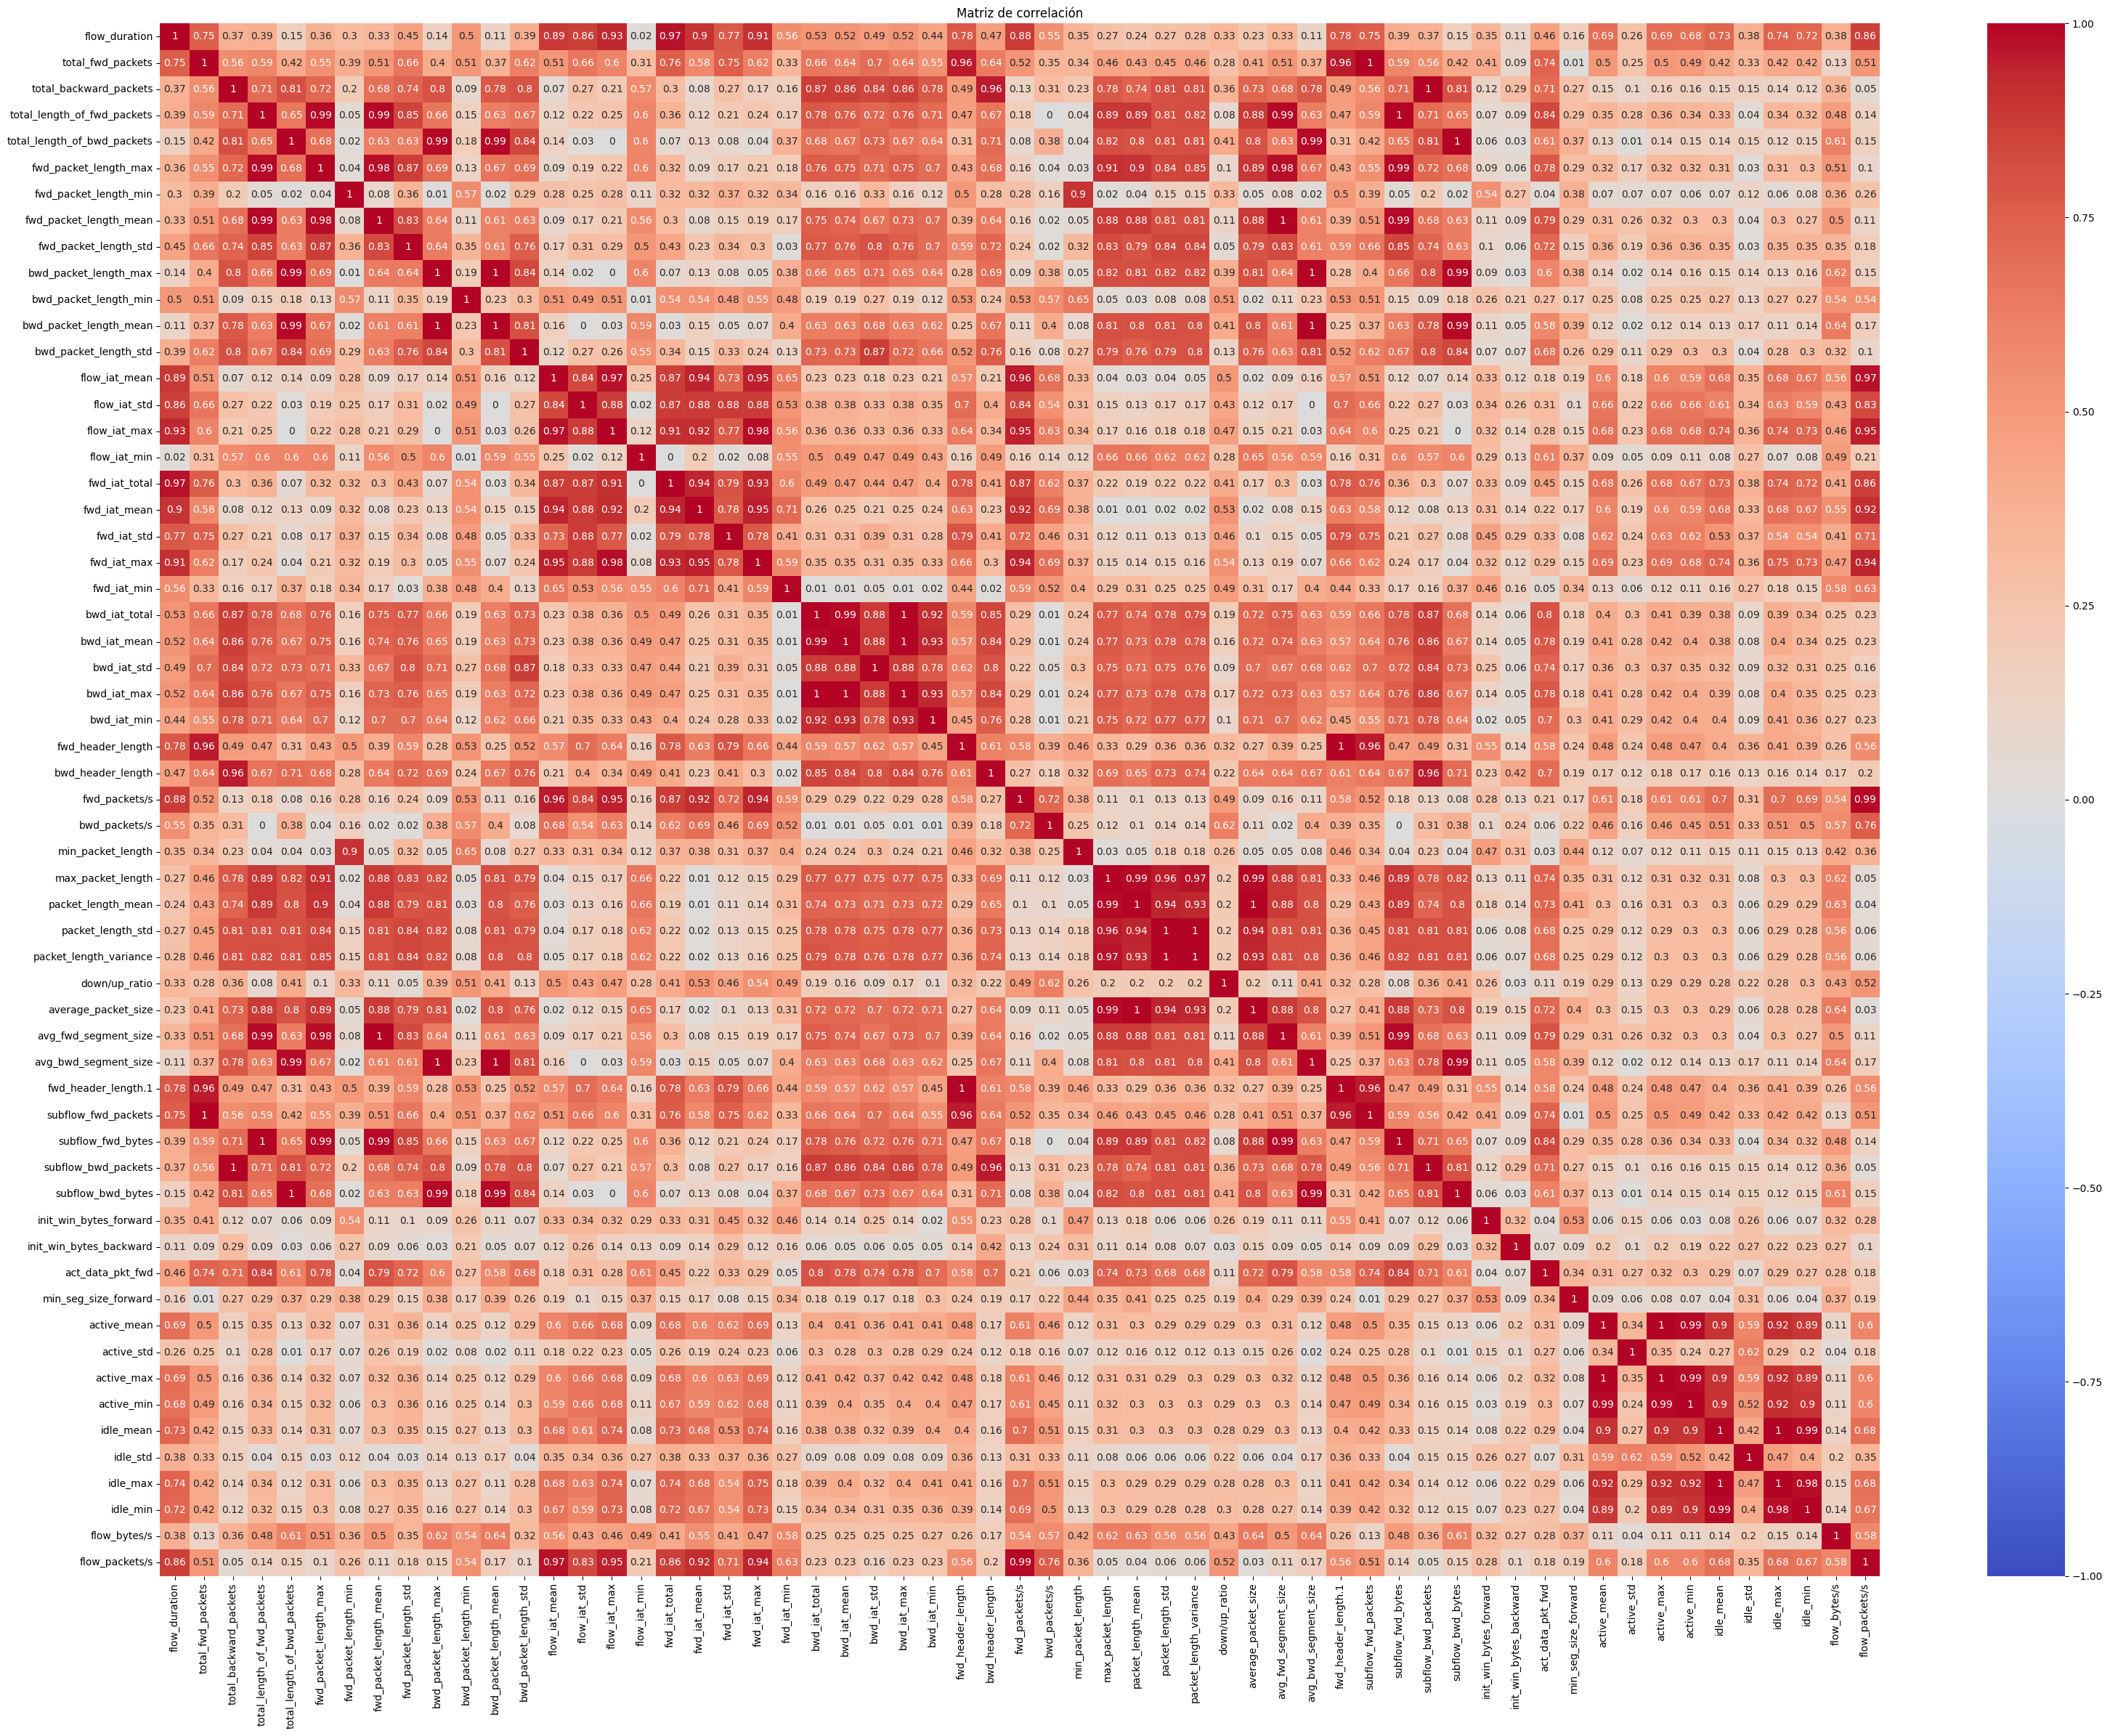


caracteristicas_alta_colinealidad : 48
['flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 'bwd_header_length', 'fwd_packets/s', 'min_packet_length', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'average_packet_size', 'avg_fwd_segment_size', 'avg_bwd_segment_size', 'fwd_header_length.1', 'subflow_fwd_packets', 'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes', 'act_data_pkt_fwd', 'active_mean', 'active_max', 'active_min', 'idle_mean', 'idle_max', 'idle_min', 'flow_packets/

In [21]:
# Prueba de Spearman para eliminación de características con alta colinealidad
nrmlzr = MinMaxScaler()
nrmlzd_chars = nrmlzr.fit_transform(X_train_clean[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito])
df_nrmlzd = pd.DataFrame(
  columns=nrmlzr.feature_names_in_,
  data=nrmlzd_chars
)
corr_matrix = generateCorrMatrix(
  data=df_nrmlzd,
  method="spearman",
  save_path="img/corr_matrix_spearman",
  abs=True
)
np.fill_diagonal(corr_matrix.values, 0)
caracteristicas_alta_colinealidad = [c for c in corr_matrix.columns if any(corr_matrix[c] >= 0.8) and corr_matrix[c].sum() > 1]
print(f"""
caracteristicas_alta_colinealidad : {len(caracteristicas_alta_colinealidad)}
{caracteristicas_alta_colinealidad} 
""")

In [22]:
# Lista de correlaciones 
lista_correlaciones = [
  ['bwd_iat_min', 'bwd_iat_mean', 'bwd_iat_max', 'bwd_iat_total'], 
  ['bwd_iat_std'], 
  ['bwd_header_length', 'total_backward_packets', 'subflow_bwd_packets'], 
  ['bwd_packet_length_std'], 
  ['bwd_packet_length_max', 'total_length_of_bwd_packets', 'subflow_bwd_bytes', 'avg_bwd_segment_size', 'bwd_packet_length_mean'], 
  ['packet_length_std', 'packet_length_variance', 'average_packet_size', 'packet_length_mean', 'max_packet_length'], 
  ['fwd_packet_length_max', 'fwd_packet_length_mean', 'avg_fwd_segment_size', 'total_length_of_fwd_packets', 'subflow_fwd_bytes'], 
  ['fwd_packet_length_std'], 
  ['act_data_pkt_fwd'],
  
  ['total_fwd_packets', 'subflow_fwd_packets', 'fwd_header_length.1', 'fwd_header_length'],
  ['fwd_iat_std'],
  ['flow_duration', 'fwd_iat_total', 'flow_iat_std', 'fwd_iat_max', 'flow_iat_max', 'fwd_iat_mean', 'fwd_packets/s', 'flow_packets/s', 'flow_iat_mean'],
  ['active_mean', 'active_max', 'active_min', 'idle_mean', 'idle_max', 'idle_min'],
  ['fwd_packet_length_min', 'min_packet_length']
]

print(len(caracteristicas_alta_colinealidad) == len(list(set(caracteristicas_alta_colinealidad))))
print(len(caracteristicas_alta_colinealidad))

True
48


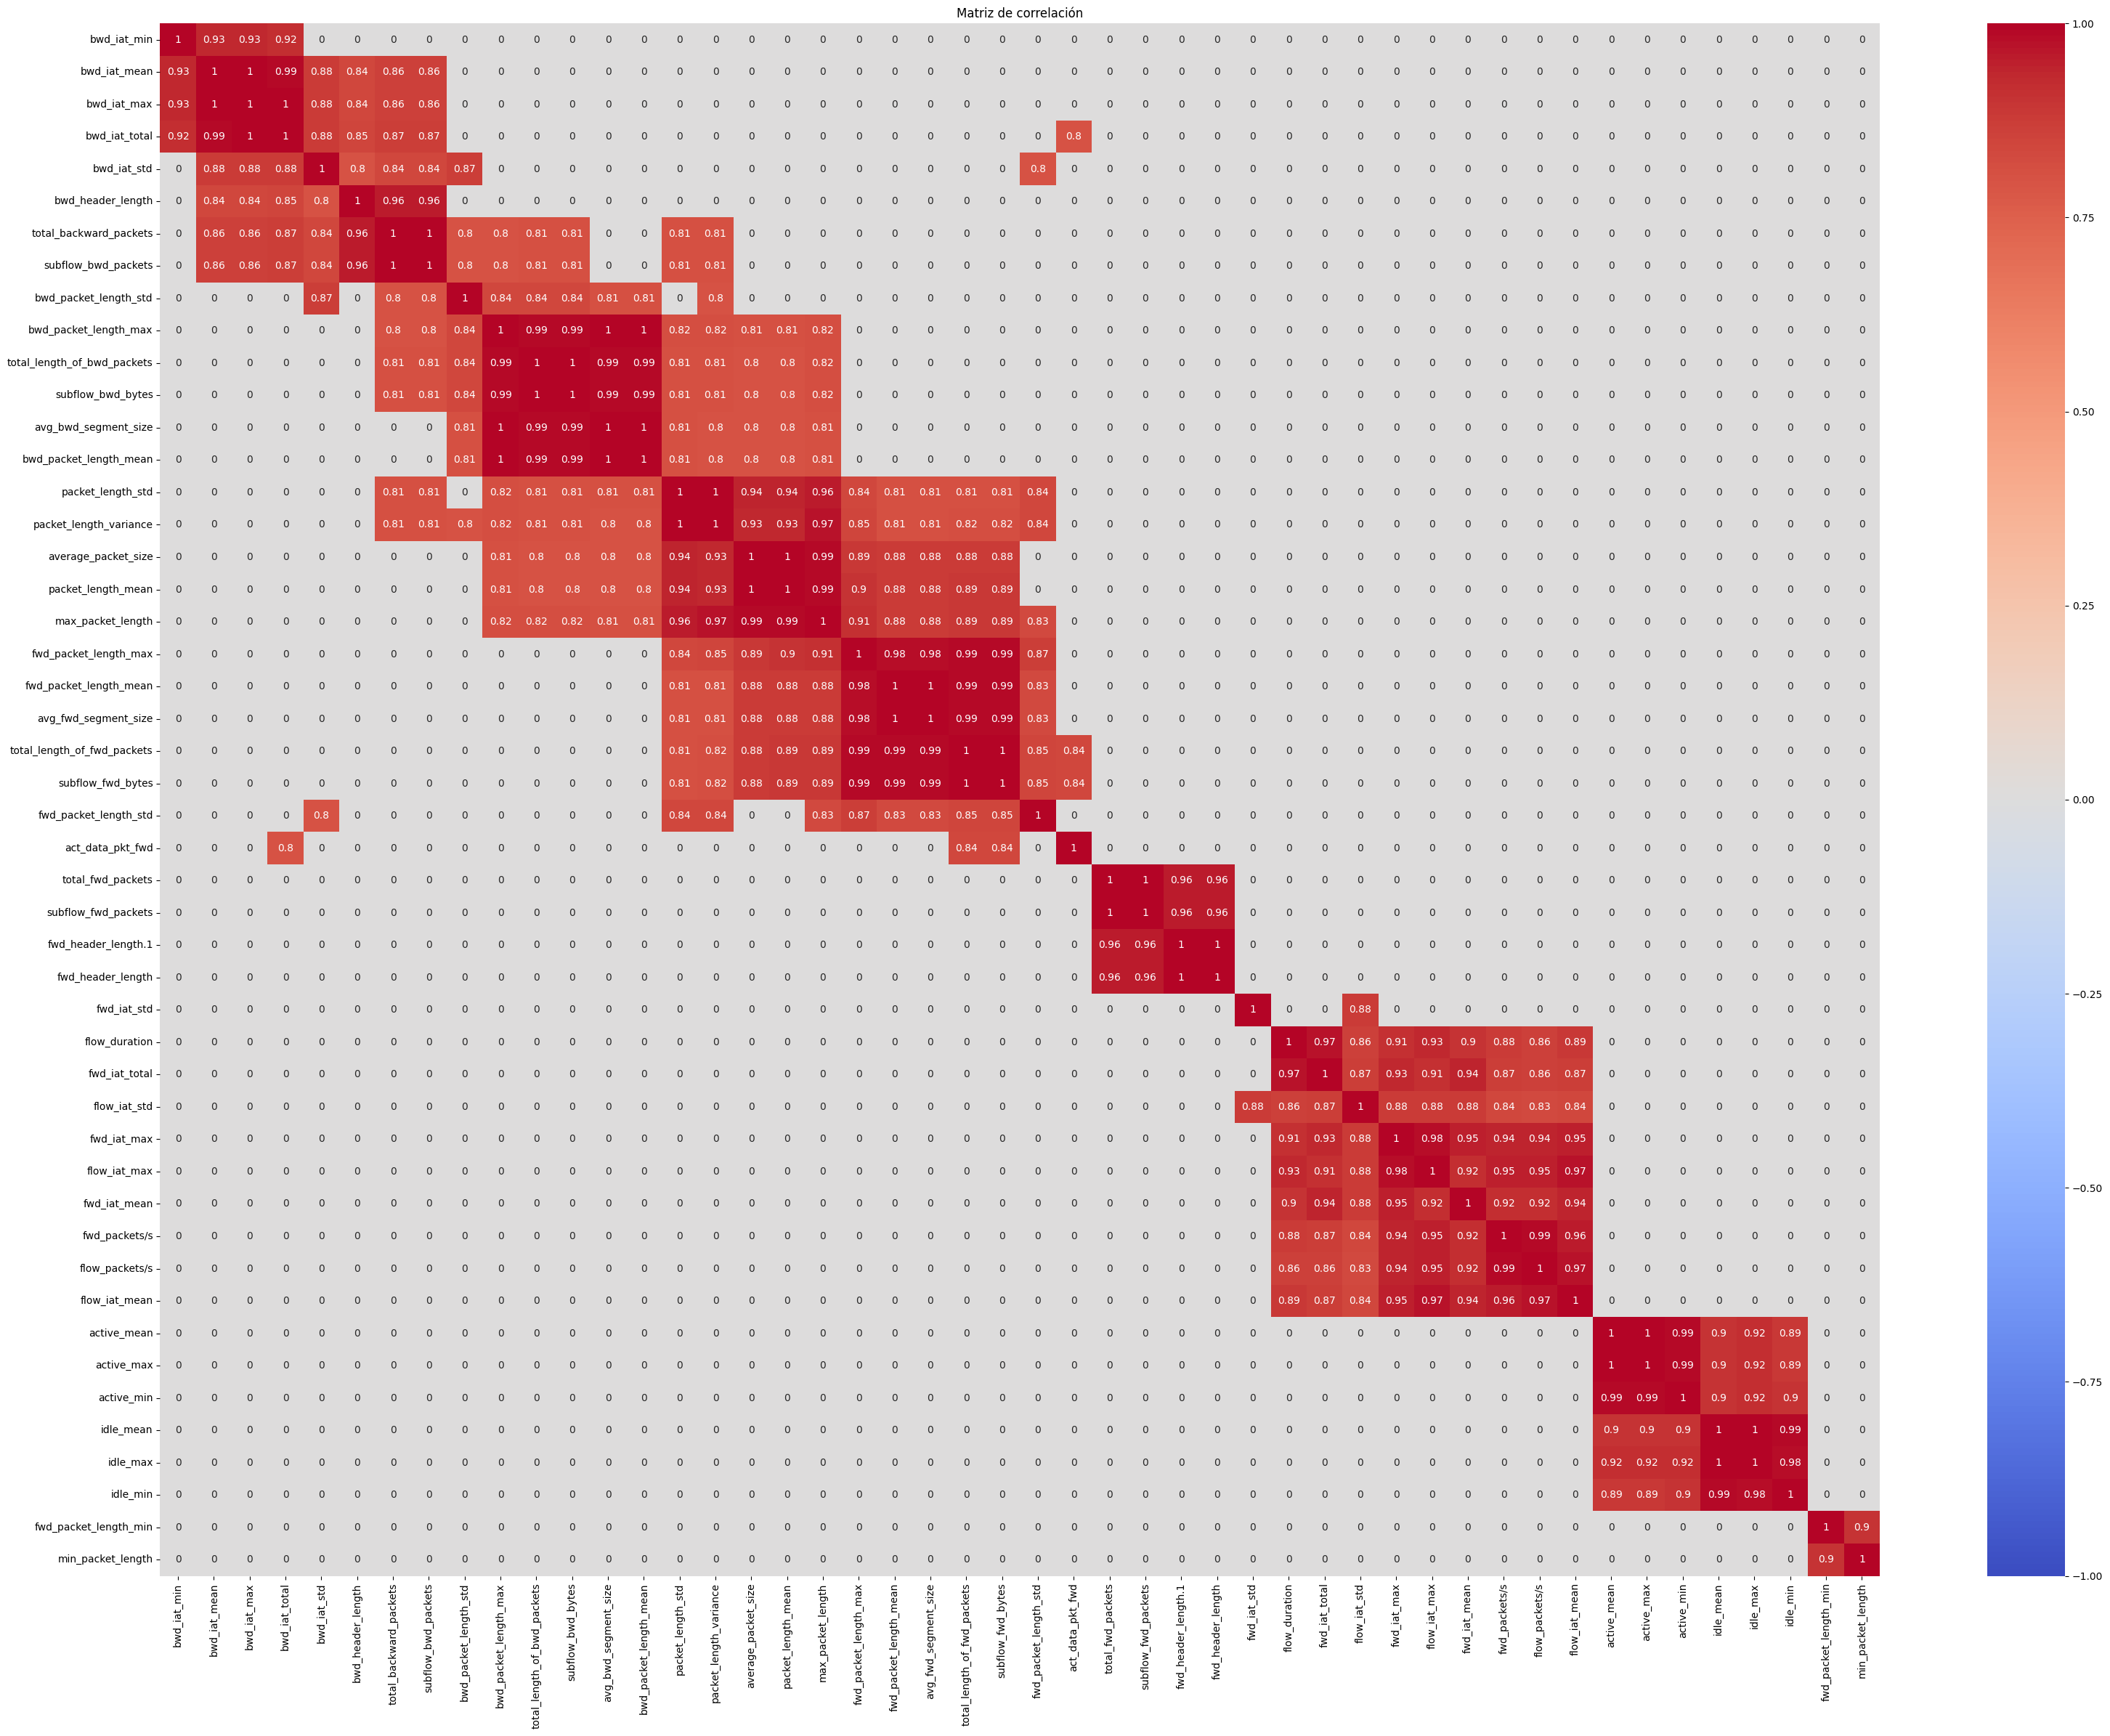

,bwd_iat_min,bwd_iat_mean,bwd_iat_max,bwd_iat_total,bwd_iat_std,bwd_header_length,total_backward_packets,subflow_bwd_packets,bwd_packet_length_std,bwd_packet_length_max,...,flow_packets/s,flow_iat_mean,active_mean,active_max,active_min,idle_mean,idle_max,idle_min,fwd_packet_length_min,min_packet_length
bwd_iat_min,1.00,0.93,0.93,0.92,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
bwd_iat_mean,0.93,1.00,1.00,0.99,0.88,0.84,0.86,0.86,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
bwd_iat_max,0.93,1.00,1.00,1.00,0.88,0.84,0.86,0.86,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
bwd_iat_total,0.92,0.99,1.00,1.00,0.88,0.85,0.87,0.87,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
bwd_iat_std,0.00,0.88,0.88,0.88,1.00,0.80,0.84,0.84,0.87,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
bwd_header_length,0.00,0.84,0.84,0.85,0.80,1.00,0.96,0.96,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
total_backward_packets,0.00,0.86,0.86,0.87,0.84,0.96,1.00,1.00,0.80,0.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
subflow_bwd_packets,0.00,0.86,0.86,0.87,0.84,0.96,1.00,1.00,0.80,0.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
bwd_packet_length_std,0.00,0.00,0.00,0.00,0.87,0.00,0.80,0.80,1.00,0.84,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
bwd_packet_length_max,0.00,0.00,0.00,0.00,0.00,0.00,0.80,0.80,0.84,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0


In [23]:
# Matriz de correlación de características correlacionadas
generateCorrMatrix(
  data=df_nrmlzd[
    # list(set(caracteristicas_alta_colinealidad))
    # caracteristicas_alta_colinealidad
    [item for sublista in lista_correlaciones for item in sublista]
  ],
  method="spearman",
  save=False,
  abs=True,
  aplicar_umbral=True,
  umbral=0.8
)

#### Obtención de residuos

In [ ]:
# Creación del dataframe de residuos
df_residuos = X_train_clean[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito]
df_residuos[caracteristica_objetivo] = y_train_clean.to_frame()[caracteristica_objetivo]

def obtener_residuos(df_new: pd.DataFrame, obj_char : str, caracteristica : str) :
  # df_new = df.copy()
  obj_tags = df_new[obj_char].unique()
  for i in obj_tags : 
    mask = df_new[obj_char] == i
    mean = df_new[mask][caracteristica].mean()
    df_new.loc[mask, caracteristica] = df_new[mask][caracteristica] - mean
  return df_new

for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito :
  df_residuos = obtener_residuos(df=df_residuos, obj_char=caracteristica_objetivo[0], caracteristica=i)
# generateBoxplot(x="flow_bytes/s", y="label", data=df_residuos, save=False)

C:\Users\User\AppData\Local\Temp\ipykernel_28568\1143499319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residuos[caracteristica_objetivo] = y_train_clean.to_frame()[caracteristica_objetivo]
C:\Users\User\AppData\Local\Temp\ipykernel_28568\1143499319.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-291357.65777189  -14778.65777189 -328019.65777189 ... -327533.65777189
 -327863.65777189 -328071.65777189]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_new.loc[mask, caracteristica] = df_new[mask][caracteristica] - mean
C:\Users\User\AppData\Local\Temp\ipykernel_28568\1143499319.py:11: FutureWarning: Setting

#### Prueba de normalidad 

In [25]:
# Prueba de Shapiro Wilk
# Ninguna característica cumple con la hipótesis de normalidad, por ello, no se puede aplicar ANOVA
df_shapiro_wilk = pd.DataFrame(columns=["característica", "estadístico", "p_valor", "pasa"])
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito :
  statistic, p_value = stats.shapiro(df_residuos[i])
  df_shapiro_wilk.loc[len(df_shapiro_wilk)] = [i, statistic, p_value, p_value >= 0.05]
df_shapiro_wilk

c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anacon

,característica,estadístico,p_valor,pasa
0,flow_duration,0.774669,4.123743e-181,False
1,total_fwd_packets,0.911730,1.881111e-149,False
2,total_backward_packets,0.793121,4.254082e-178,False
3,total_length_of_fwd_packets,0.785678,2.428186e-179,False
4,total_length_of_bwd_packets,0.749955,8.127094e-185,False
5,fwd_packet_length_max,0.914812,2.595715e-148,False
6,fwd_packet_length_min,0.541918,4.008945e-207,False
7,fwd_packet_length_mean,0.851153,1.004934e-166,False
8,fwd_packet_length_std,0.926517,1.283121e-143,False
9,bwd_packet_length_max,0.675138,2.646174e-194,False


In [26]:
# Prueba de Kolmogorov Smirnov
df_kolmogorov_smirnov = pd.DataFrame(columns=["característica", "estadístico", "p_valor", "pasa"])
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito :
  statistic, p_value = stats.kstest((df_residuos[i]-df_residuos[i].mean())/df_residuos[i].std(), stats.norm.cdf)
  df_kolmogorov_smirnov.loc[len(df_kolmogorov_smirnov)] = [i, statistic, p_value, p_value >= 0.05]
df_kolmogorov_smirnov

,característica,estadístico,p_valor,pasa
0,flow_duration,0.282268,0.0,False
1,total_fwd_packets,0.147792,0.0,False
2,total_backward_packets,0.209157,0.0,False
3,total_length_of_fwd_packets,0.247145,0.0,False
4,total_length_of_bwd_packets,0.325292,0.0,False
5,fwd_packet_length_max,0.190752,0.0,False
6,fwd_packet_length_min,0.338662,0.0,False
7,fwd_packet_length_mean,0.213705,0.0,False
8,fwd_packet_length_std,0.197209,0.0,False
9,bwd_packet_length_max,0.318504,0.0,False


#### Prueba Kruskal Wallis

In [27]:
df_train_clean = X_train_clean[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito]
df_train_clean["label"] = y_train_clean.to_frame()

df_kruskal = pd.DataFrame(columns=["caracteristica", "estadistico", "p_valor", "pasa"])

for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito : 
  grupos = [group[i].values for name, group in df_train_clean.groupby('label')]

  stat, p_value = stats.kruskal(*grupos)
  df_kruskal.loc[len(df_kruskal)] = [i, stat, p_value, p_value < 0.05]

df_kruskal.sort_values(by='estadistico', ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_28568\3044818024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_clean["label"] = y_train_clean.to_frame()


,caracteristica,estadistico,p_valor,pasa
10,bwd_packet_length_min,661372.898086,0.0,True
46,init_win_bytes_backward,649981.554094,0.0,True
30,bwd_packets/s,646384.417609,0.0,True
58,flow_packets/s,643206.428663,0.0,True
29,fwd_packets/s,615302.108685,0.0,True
48,min_seg_size_forward,597965.199823,0.0,True
13,flow_iat_mean,596058.426209,0.0,True
57,flow_bytes/s,580122.587760,0.0,True
20,fwd_iat_max,577611.593360,0.0,True
15,flow_iat_max,562553.935193,0.0,True


#### Prueba de Información Mutua

In [28]:
mi_scores = mutual_info_classif(X_train_clean, y_train_clean, discrete_features=list(range(len(list(chars_encoder.get_feature_names_out())+caracteristicas_binarias))))

In [29]:
df_mi_scores = pd.DataFrame()
df_mi_scores["caracteristica"] = X_train_clean.columns
df_mi_scores["scores"] = mi_scores

df_mi_scores = df_mi_scores.sort_values(by="scores", ascending=False)

df_mi_scores.head(30)

,caracteristica,scores
70,flow_packets/s,2.043852
25,flow_iat_mean,2.023650
41,fwd_packets/s,2.003234
27,flow_iat_max,1.954531
12,flow_duration,1.909286
32,fwd_iat_max,1.890930
42,bwd_packets/s,1.874331
30,fwd_iat_mean,1.846521
52,fwd_header_length.1,1.802763
39,fwd_header_length,1.802570


#### Selección final de características

In [ ]:
chars_per_correlacion = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
selected_chars = []
for i in range(len(lista_correlaciones)) : 
  mask = np.isin(df_mi_scores["caracteristica"], lista_correlaciones[i])
  for j in df_mi_scores[mask]["caracteristica"][:chars_per_correlacion[i]].to_list() :
      selected_chars.append(j)
      print(f"""
            característica seleccionada : {j}
            información mutua : {df_mi_scores[df_mi_scores["caracteristica"] == j]["scores"].values[0]}
      """)
selected_chars


            característica seleccionada : bwd_iat_max
            información mutua : 1.0414065489762026
      

            característica seleccionada : bwd_iat_std
            información mutua : 0.8477059644914
      

            característica seleccionada : bwd_header_length
            información mutua : 1.5187497010927113
      

            característica seleccionada : bwd_packet_length_std
            información mutua : 0.797745471202707
      

            característica seleccionada : avg_bwd_segment_size
            información mutua : 1.278775535471667
      

            característica seleccionada : average_packet_size
            información mutua : 1.691350516445332
      

            característica seleccionada : subflow_fwd_bytes
            información mutua : 1.4873884190846054
      

            característica seleccionada : fwd_packet_length_std
            información mutua : 1.00771936621924
      

            característica seleccionada : act_data_pkt

['bwd_iat_max',
 'bwd_iat_std',
 'bwd_header_length',
 'bwd_packet_length_std',
 'avg_bwd_segment_size',
 'average_packet_size',
 'subflow_fwd_bytes',
 'fwd_packet_length_std',
 'act_data_pkt_fwd',
 'fwd_header_length.1',
 'fwd_iat_std',
 'flow_packets/s',
 'idle_mean',
 'fwd_packet_length_min']

#### Revisión de características seleccionadas

In [31]:
# Se seleccionó un total de 30 características para el dataset, cabe resaltar que las características son en su totalidad numéricas
print(f"""
Características seleccionadas : {len(selected_chars)}
{selected_chars}
""")



Características seleccionadas : 14
['bwd_iat_max', 'bwd_iat_std', 'bwd_header_length', 'bwd_packet_length_std', 'avg_bwd_segment_size', 'average_packet_size', 'subflow_fwd_bytes', 'fwd_packet_length_std', 'act_data_pkt_fwd', 'fwd_header_length.1', 'fwd_iat_std', 'flow_packets/s', 'idle_mean', 'fwd_packet_length_min']



### Normalización de características

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1), clip=True)
chars_nrmlzd = scaler.fit_transform(X_train_clean[selected_chars])
X_train_final = pd.DataFrame(
  columns=scaler.get_feature_names_out(),
  data=chars_nrmlzd
)
X_train_final.describe()

,bwd_iat_max,bwd_iat_std,bwd_header_length,bwd_packet_length_std,avg_bwd_segment_size,average_packet_size,subflow_fwd_bytes,fwd_packet_length_std,act_data_pkt_fwd,fwd_header_length.1,fwd_iat_std,flow_packets/s,idle_mean,fwd_packet_length_min
count,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000,947746.000000
mean,0.048331,0.018944,0.083660,0.072283,0.090126,0.098146,0.099055,0.088610,0.091228,0.135321,0.064392,0.110335,0.069348,0.023232
std,0.165186,0.087187,0.152065,0.170598,0.198167,0.193517,0.220789,0.148968,0.170562,0.137670,0.134455,0.233280,0.178247,0.086640
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.013736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057554,0.000000,0.000009,0.000000,0.000000
50%,0.000000,0.000000,0.027473,0.000000,0.000517,0.004516,0.005510,0.000000,0.000000,0.093525,0.010496,0.000019,0.000000,0.000000
75%,0.004306,0.001267,0.076923,0.002174,0.021511,0.050677,0.085006,0.194022,0.090909,0.169065,0.057149,0.011085,0.045940,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
label_encoder = LabelBinarizer()
labels_encoded = label_encoder.fit_transform(y_train_clean)
y_train_final = pd.DataFrame(
  columns=label_encoder.classes_,
  data=labels_encoded
)
y_train_clean

0                 BENIGN
1                 BENIGN
2                 BENIGN
3                 BENIGN
4               PORTSCAN
               ...      
951114    WEB_ATTACK_XSS
951115    WEB_ATTACK_XSS
951116    WEB_ATTACK_XSS
951117    WEB_ATTACK_XSS
951118    WEB_ATTACK_XSS
Name: label, Length: 947746, dtype: object

### Integración de datos

In [34]:
X_train_final.to_csv("../4_modelado/DB/X_train.csv", index=False)
y_train_clean.to_csv("../4_modelado/DB/y_train.csv", index=False)

medians = {
  "flow_bytes/s" : X_train_clean["flow_bytes/s"].median(),
  "flow_packets/s" : X_train_clean["flow_packets/s"].median()
}

maxs = {
 "flow_bytes/s" : X_train_clean["flow_bytes/s"].max(),
 "flow_packets/s" : X_train_clean["flow_packets/s"].max()
}

## Tratamiento del conjunto de validación y prueba

In [35]:
def procesamiento_df_valid_test(X: pd.DataFrame, y : pd.core.series.Series) : 
  X_new = X.copy()
  """ Limpieza de datos """
  # Valores nulos
  X_new.loc[X_new[caracteristicas_valores_nulos].isna(), caracteristicas_valores_nulos] = medians[caracteristicas_valores_nulos]
  # Valores infinitos
  for i in caracteristicas_con_valor_maximo_infinito :
    X_new.loc[np.isinf(X_new[i]), i] = np.nan
    X_new.loc[np.isnan(X_new[i]), i] = maxs[i]
  """ Selección de datos relevantes """
  X_new = X_new[selected_chars]
  """ Construcción de nuevos datos e Integración de datos"""
  chars_nrmlzd = scaler.transform(X_new)
  X_final = pd.DataFrame(
    columns=scaler.get_feature_names_out(),
    data=chars_nrmlzd
  )
  labels_encoded = label_encoder.transform(y)
  y_final = pd.DataFrame(
    columns=label_encoder.classes_,
    data=labels_encoded
  )
  return X_final, y

In [36]:
X_valid_final, y_valid_final = procesamiento_df_valid_test(
  X=df_valid.drop(caracteristica_objetivo, axis=1),
  y=df_valid[caracteristica_objetivo[0]]
)

X_valid_final.describe()

X_valid_final.to_csv("../4_modelado/DB/X_valid.csv", index=False)
y_valid_final.to_csv("../4_modelado/DB/y_valid.csv", index=False)

In [37]:
X_test_final, y_test_final = procesamiento_df_valid_test(
  X=df_test.drop(caracteristica_objetivo, axis=1),
  y=df_test[caracteristica_objetivo[0]]
)

X_test_final.describe()

X_test_final.to_csv("../4_modelado/DB/X_test.csv", index=False)
y_test_final.to_csv("../4_modelado/DB/y_test.csv", index=False)